## PIMS Hackathon, Seattle 2025
### Project B - Preconditioners for Thermal Radiative Transfer
Packages: jupyter, numpy, matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from library import *

(300, 300) (300, 300) (300, 300) (300, 300)
L2  : 0.0016233465555306112
Linf: 0.002205512666996423


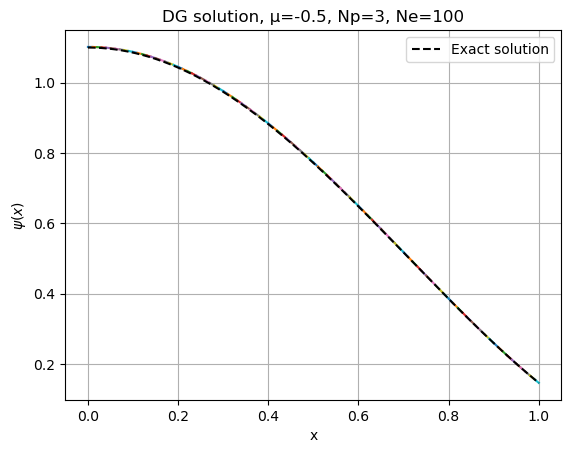

In [2]:
# ─── Example usage (Simple DG) ───

# Parameters for the transport problem
μ      = -0.5
ψ_MMS  = lambda x: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x)) # Manufactures solution
σ_t    = lambda x: x**2 + 1
source = lambda x: (μ**3)*(2*x - 6.8*np.sin(2*x)) + (σ_t(x) * (μ**2)*((x**2 +1) + 3.4*np.cos(2*x)))
inflow = lambda x: ψ_MMS(x)

# Mesh parameters
xs = np.linspace(0, 1, 101) # Mesh points / element boundaries
Np = 3                      # Legendre polynomials per element (basis size)

# Solve
ψ_weights = transport_direct_solve(μ, σ_t, source, inflow, Np, xs)

# Print the error in the solution
print("L2  :",error_Lp(ψ_weights, xs, Np, ψ_MMS, p=2))
print("Linf:",error_Lp(ψ_weights, xs, Np, ψ_MMS, p='inf'))

# Plot numerical solution against the exact solution (MMS)
plot_solution(ψ_weights, xs, Np, μ=μ, exact_ψ_func=ψ_MMS)

L2  : 13.601511825091677
Linf: 15.29783480340328


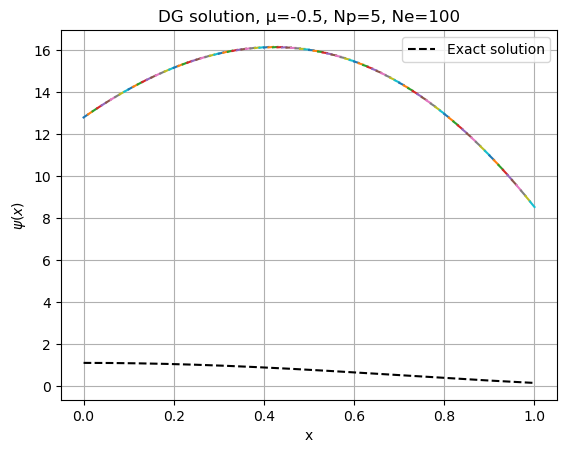

In [ ]:
# ─── Example usage (Fixed point iteration) ───

# Parameters for the transport problem
ψ_MMS  = lambda x: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x)) # Manufactures solution
σ_t    = lambda x: x**2 + 1
σ_a    = lambda x: x**2 + 1
ε      = 1
source = lambda x,μ = 1: (μ**3)/ε * (2*x - 6.8*np.sin(2*x)) + (σ_t(x)/ε**2 * ψ_MMS(x)) \
                   - (σ_t(x)/ε - ε*σ_a(x)) / (3*ε) * ψ_MMS(x)
inflow = lambda x: ψ_MMS(x)
 
# Mesh parameters
Np = 5                      # Legendre polynomials per element (basis size)
Nμ = 5                      # Legendre polynomials per element (basis size)
Nt = 5                      # Legendre polynomials per element (basis size)
xs = np.linspace(0, 1, 101) # Mesh points / element boundaries

# Solve
ψ_weights_all, μs = transport_direct_solve_diffusive(σ_t, σ_a, ε, source, inflow, Np, Nμ, Nt, xs)

# Print the error in the solution
print("L2  :",error_Lp(ψ_weights_all[2,:], xs, Np, ψ_MMS, p=2))
print("Linf:",error_Lp(ψ_weights_all[2,:], xs, Np, ψ_MMS, p='inf'))

# Plot numerical solution against the exact solution (MMS)
plot_solution(ψ_weights_all[2,:], xs, Np, μ=μ, exact_ψ_func=ψ_MMS)

In [16]:
ψ_weights.reshape((3,100)).shape

(3, 100)

In [14]:
A = [1,2,3]
A = np.array(A)
B = np.ones((3, 4))
(A.reshape((-1, 1))*B).sum(axis=0)

array([6., 6., 6., 6.])